In [ ]:

import jupyter_energi
jupyter_energi.notebook_path = 'Demo.ipynb'

In [54]:
%%capture
#EnergiBridgeStart
from time import sleep

for i in range(3):
    sleep(1)
#EnergiBridgeStop

data = jupyter_energi.run(no_runs=30)


In [55]:
#print(data)


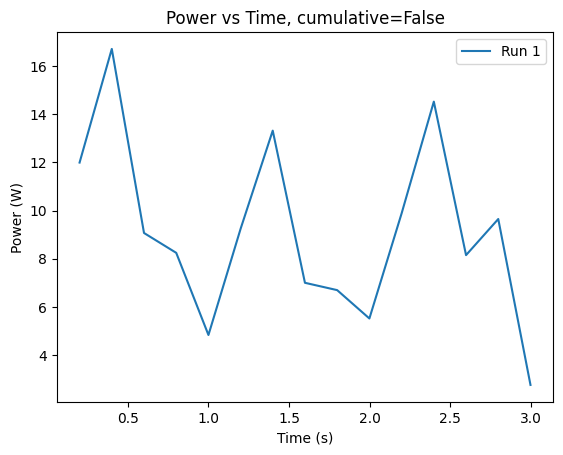

In [5]:
cumulative = False
time_and_power = jupyter_energi.extract_time_and_power(data, cumulative)
jupyter_energi.make_time_series_plot(time_and_power, cumulative)

In [ ]:
time_power_dataset = jupyter_energi.extract_time_and_power(data, cumulative)
std_dev = 1
jupyter_energi.make_violin_plot(time_power_dataset, std_dev=std_dev)


In [3]:
some_code = '''
from time import sleep
for i in range(3):
    sleep(1)
    print(i)
    
'''

data = jupyter_energi.run(some_code)


0
1
2
Energy consumption in joules: 26.7724609375 for 3.228235 sec of execution.


C:\Users\David\git\EnergiBridgeWrapper\jupyter_energi\jupyter_energi.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data.append(pd.read_csv('temp.csv'))


In [6]:
%%capture
data = jupyter_energi.run(no_runs=3)

0
1
2
Energy consumption in joules: 75.8472900390625 for 3.2332234 sec of execution.

0
1
2
Energy consumption in joules: 68.2825927734375 for 3.2225492 sec of execution.

0
1
2
Energy consumption in joules: 54.92193603515625 for 3.2229538 sec of execution.


In [8]:
#print(data)

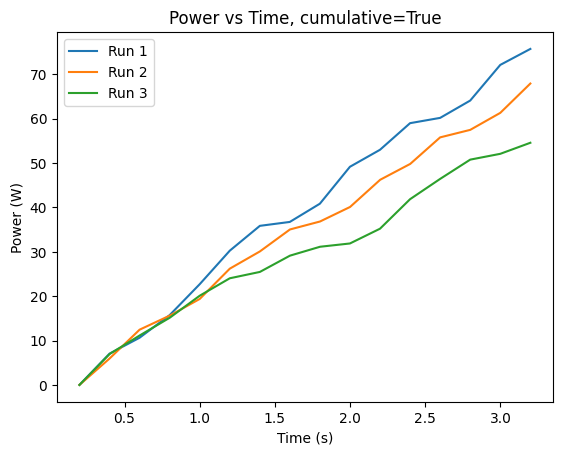

In [7]:
cumulative = True
time_and_power = jupyter_energi.extract_time_and_power(data, cumulative)
jupyter_energi.make_time_series_plot(time_and_power, cumulative)

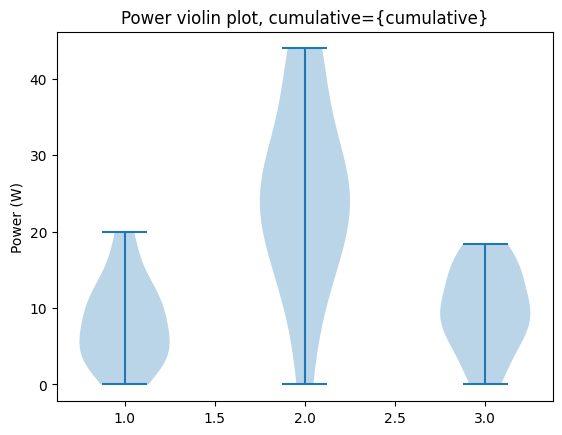

In [11]:
jupyter_energi.make_violin_plot(time_and_power, True)

# Validation

code taken from https://nbviewer.org/urls/qutip.org/qutip-tutorials/tutorials-v4/heom/heom-4-dynamical-decoupling.ipynb

In [8]:
program = '''
import sys
import subprocess
#subprocess.check_call([sys.executable, "-m", "pip", "install", "ipykernel"])
import numpy as np
import matplotlib.pyplot as plt

import qutip
from qutip import (
    Options,
    QobjEvo,
    basis,
    expect,
    ket2dm,
    sigmax,
    sigmaz,
)
from qutip.nonmarkov.heom import (
    HEOMSolver,
    DrudeLorentzPadeBath,
)

def dl_spectrum(w, lam, gamma):
    """ Return the Drude-Lorentz spectral density. """
    J = w * 2 * lam * gamma / (gamma**2 + w**2)
    return J
    
# Define the system Hamlitonian.
#
# The system isn't evolving by itself, so the Hamiltonian is 0 (with the
# correct dimensions):

H_sys = 0 * sigmaz()

# Define some operators with which we will measure the system
# 1,1 element of density matrix - corresonding to groundstate
P11p = basis(2, 0) * basis(2, 0).dag()
P22p = basis(2, 1) * basis(2, 1).dag()
# 1,2 element of density matrix  - corresonding to coherence
P12p = basis(2, 0) * basis(2, 1).dag()

# Properties for the Drude-Lorentz bath

lam = 0.0005
gamma = 0.005
T = 0.05

# bath-system coupling operator:
Q = sigmaz()

# number of terms to keep in the expansion of the bath correlation function:
Nk = 3

bath = DrudeLorentzPadeBath(Q, lam=lam, gamma=gamma, T=T, Nk=Nk)

# HEOM parameters

# number of layers to keep in the hierarchy:
NC = 6

def drive(amplitude, delay, integral):
    """ Coefficient of the drive as a function of time.

        The drive consists of a series of constant pulses with
        a fixed delay between them.

        Parameters
        ----------
        amplitude : float
            The amplitude of the drive during the pulse.
        delay : float
            The time delay between successive pulses.
        integral : float
            The integral of the pulse. This determines
            the duration of each pulse with the duration
            equal to the integral divided by the amplitude.
    """
    duration = integral / amplitude
    period = duration + delay

    def pulse(t):
        t = t % period
        if t < duration:
            return amplitude
        return 0

    return pulse


H_drive = sigmax()

wlist = np.linspace(0, 0.5, 1000)
J = dl_spectrum(wlist, lam, gamma)


# Fast driving (quick, large amplitude pulses)

# The max_step must be set to a short time than the
# length of the shortest pulse, otherwise the solver
# might skip over a pulse.
options = Options(
    nsteps=1500,
    store_states=True,
    rtol=1e-12,
    atol=1e-12,
    max_step=1 / 20.0,
)

tlist = np.linspace(0, 400, 1000)

# start with a superposition so there is something to dephase!
rho0 = (basis(2, 1) + basis(2, 0)).unit()
rho0 = ket2dm(rho0)

# without pulses
hsolver = HEOMSolver(H_sys, bath, NC, options=options)
outputnoDD = hsolver.run(rho0, tlist, ado_return=True)

# with pulses
drive_fast = drive(amplitude=0.5, delay=20, integral=np.pi / 2)
H_d = qutip.QobjEvo([H_sys, [H_drive, drive_fast]])

hsolver = HEOMSolver(H_d, bath, NC, options=options)
outputDD = hsolver.run(rho0, tlist, ado_return=True)

# Slow driving (longer, small amplitude pulses)

# without pulses
hsolver = HEOMSolver(H_sys, bath, NC, options=options)
outputnoDDslow = hsolver.run(rho0, tlist, ado_return=True)

# with pulses
drive_slow = drive(amplitude=0.01, delay=20, integral=np.pi/2)
H_d = [H_sys, [H_drive, drive_slow]]

hsolver = HEOMSolver(H_d, bath, NC, options=options)
outputDDslow = hsolver.run(rho0, tlist, ado_return=True)

def plot_dd_results(outputnoDD, outputDD, outputDDslow):
    fig, axes = plt.subplots(2, 1, sharex=False, figsize=(12, 12))

    # Plot the dynamic decoupling results:

    tlist = outputDD.times

    P12 = basis(2, 1) * basis(2, 0).dag()
    P12DD = qutip.expect(outputDD.states, P12)
    P12noDD = qutip.expect(outputnoDD.states, P12)
    P12DDslow = qutip.expect(outputDDslow.states, P12)

    plt.sca(axes[0])
    plt.yticks([0, 0.25, 0.5], [0, 0.25, 0.5])

    axes[0].plot(
        tlist, np.real(P12DD),
        'green', linestyle='-', linewidth=2, label="HEOM with fast DD",
    )
    axes[0].plot(
        tlist, np.real(P12DDslow),
        'blue', linestyle='-', linewidth=2, label="HEOM with slow DD",
    )
    axes[0].plot(
        tlist, np.real(P12noDD),
        'orange', linestyle='--', linewidth=2, label="HEOM no DD",
    )

    axes[0].locator_params(axis='y', nbins=3)
    axes[0].locator_params(axis='x', nbins=3)

    axes[0].set_ylabel(r"$rho_{01}$", fontsize=30)

    axes[0].legend(loc=4)
    axes[0].text(0, 0.4, "(a)", fontsize=28)

    # Plot the drive pulses:

    pulse = [drive_fast(t) for t in tlist]
    pulseslow = [drive_slow(t) for t in tlist]

    plt.sca(axes[1])
    plt.yticks([0., 0.25, 0.5], [0, 0.25, 0.5])

    axes[1].plot(
        tlist, pulse,
        'green', linestyle='-', linewidth=2, label="Drive fast",
    )
    axes[1].plot(
        tlist, pulseslow,
        'blue', linestyle='--', linewidth=2, label="Drive slow",
    )

    axes[1].locator_params(axis='y', nbins=3)
    axes[1].locator_params(axis='x', nbins=3)


    axes[1].legend(loc=1)
    axes[1].text(0, 0.4, "(b)", fontsize=28)

    fig.tight_layout()
    
plot_dd_results(outputnoDD, outputDD, outputDDslow)
'''

In [17]:
%%capture
data = jupyter_energi.run(program, no_runs=30)

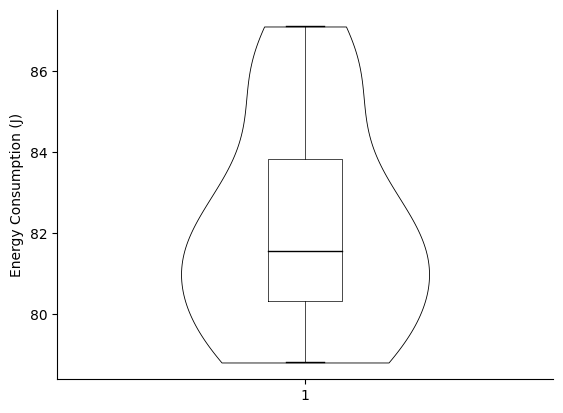

In [61]:
cumulative = False
time_power_dataset = jupyter_energi.extract_time_and_power(data, cumulative)
jupyter_energi.make_violin_plot(time_power_dataset,)